<a href="https://colab.research.google.com/github/raagzz/jewelry-design-pattern-identification/blob/main/similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Similarity Search using Vision-Transformer and FAISS

In [ ]:
!pip install datasets
!pip install faiss-cpu

## Import Libraries and Models

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import faiss

from transformers import AutoFeatureExtractor, AutoModel
from datasets import load_from_disk, load_dataset

from faiss import write_index, read_index

In [ ]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint, attn_implementation="eager")

hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Loading the Dataset

### Loading from Images

In [ ]:
# !unzip /content/drive/MyDrive/Jewelry/Image_V2.zip -d /content/jewelry_images

In [ ]:
dataset = load_dataset("imagefolder", data_dir="jewelry_images")

Resolving data files:   0%|          | 0/9543 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]
    return examples

dataset = dataset.map(transforms, batched=True)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

In [ ]:
dataset.save_to_disk('jewelry_images_processed')

Saving the dataset (0/2 shards):   0%|          | 0/9543 [00:00<?, ? examples/s]

### Loading from Disk

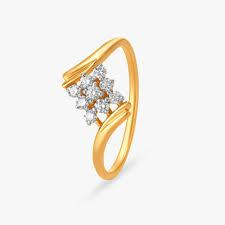

In [ ]:
dataset = load_from_disk('/content/drive/MyDrive/jewelry_images_processed')
candidate_images = dataset["train"]

candidate_images[1]['image']

## Feature Extraction using ViT

In [ ]:
transformation_chain = T.Compose(
    [
        T.Resize(int((256 / 224) * extractor.size['height'])),
        T.CenterCrop(extractor.size['height']),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [ ]:
def extract_embeddings(model: torch.nn.Module):
    device = model.device

    def pp(batch):
        images = batch["image"]

        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_embeddings = candidate_images.map(extract_fn, batched=True, batch_size=batch_size)

In [ ]:
embeddings = np.array(candidate_embeddings["embeddings"])

## Getting the Test Embedding

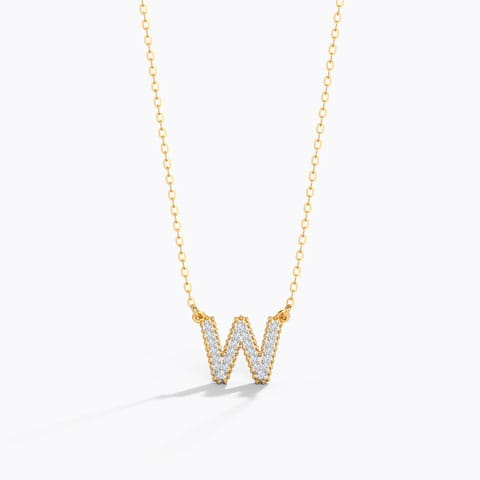

In [ ]:
test_idx = np.random.choice(len(candidate_images))
test_sample = candidate_images[test_idx]["image"]
test_sample

In [ ]:
def get_test_embedding(test_sample):
    device = model.device

    image_transformed = transformation_chain(test_sample).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}
    with torch.no_grad():
        query_embeddings = np.array(model(**new_batch).last_hidden_state[:, 0].cpu())
    return query_embeddings

search_vector = get_test_embedding(test_sample)

In [ ]:
search_vector.shape

(1, 768)

In [ ]:
search_vector[0][:10]

array([-0.09571612, -0.2896177 , -0.2089333 ,  0.2531286 , -0.10032701,
       -0.13692063,  0.04407905,  0.1859466 ,  0.03442223,  0.05519433],
      dtype=float32)

## Storing the Embeddings using FAISS

### Using FlatIndex

In [ ]:
flat_index = faiss.IndexFlatL2(embeddings.shape[1])
flat_index.add(embeddings)
write_index(flat_index, "flat_embeddings.index")

In [ ]:
faiss.normalize_L2(search_vector)
flat_index = read_index("flat_embeddings.index")

In [ ]:
%%timeit
flat_distances, flat_indices = flat_index.search(search_vector, flat_index.ntotal)

3.64 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
flat_distances, flat_indices = flat_index.search(search_vector, flat_index.ntotal)

In [ ]:
os.path.getsize("flat_embeddings.index")

29316141

### Using PQIndex (Product Quantization)

In [ ]:
m = 8 # the number of subvectors we’d like to split our full vectors into.
nbits = 8 # the number of bits that each subquantizer can use.

pq_index = faiss.IndexPQ(embeddings.shape[1], m, nbits)
pq_index.train(embeddings)
pq_index.add(embeddings)

write_index(pq_index, "pq_embeddings.index")

In [ ]:
pq_index = read_index("pq_embeddings.index")

In [ ]:
%%timeit
pq_distances, pq_indices = pq_index.search(search_vector, pq_index.ntotal)

2.32 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
pq_distances, pq_indices = pq_index.search(search_vector, pq_index.ntotal)

In [ ]:
os.path.getsize("pq_embeddings.index")

862862

### Comparisons

|Index|Memory|Time|
|-----|------|----|
|Flat|29316141|3.64ms|
|PQ|862862|2.32ms|

PQ has memory reduction of 97.1% and a speed-up of 36.2%.

## Inferences

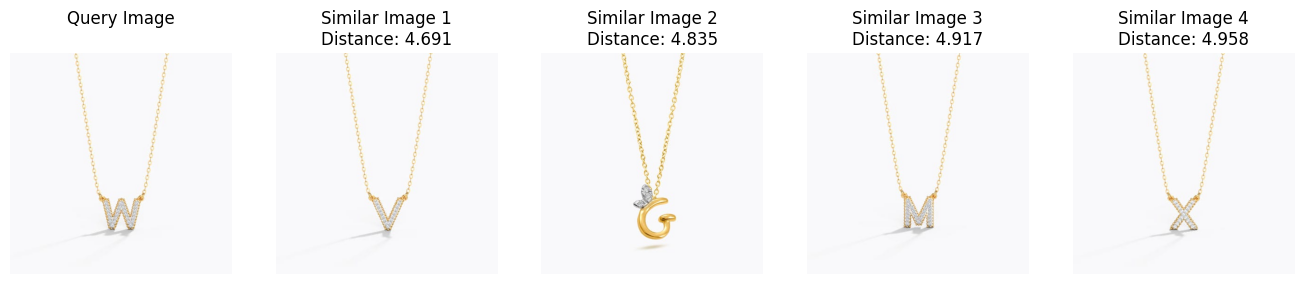

In [ ]:
def plot_images(indices, distances, k):
    indices = indices[0][:k]
    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, idx) in enumerate(indices):
        ax = plt.subplot(int(len(indices) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n")
        else:
            ax.set_title(
                "Similar Image " + str(i) + f"\nDistance: {distances[0][i]:.3f}"
            )
        plt.imshow(np.array(candidate_images[int(idx)]['image']).astype("int"))
        plt.axis("off")

plot_images(pq_indices, pq_distances, 5)

## Visualizing using Attention Map

In [ ]:
def get_attention_map(img, get_mask=False):
    x = transformation_chain(img).unsqueeze(0)
    x.size()
    new_batch = {"pixel_values": x}

    logits, att_mat = model(**new_batch, output_attentions=True).last_hidden_state, model(**new_batch, output_attentions=True).attentions
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")

    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    plt.axis("off")
    _ = ax2.imshow(att_map)
    plt.axis("off")

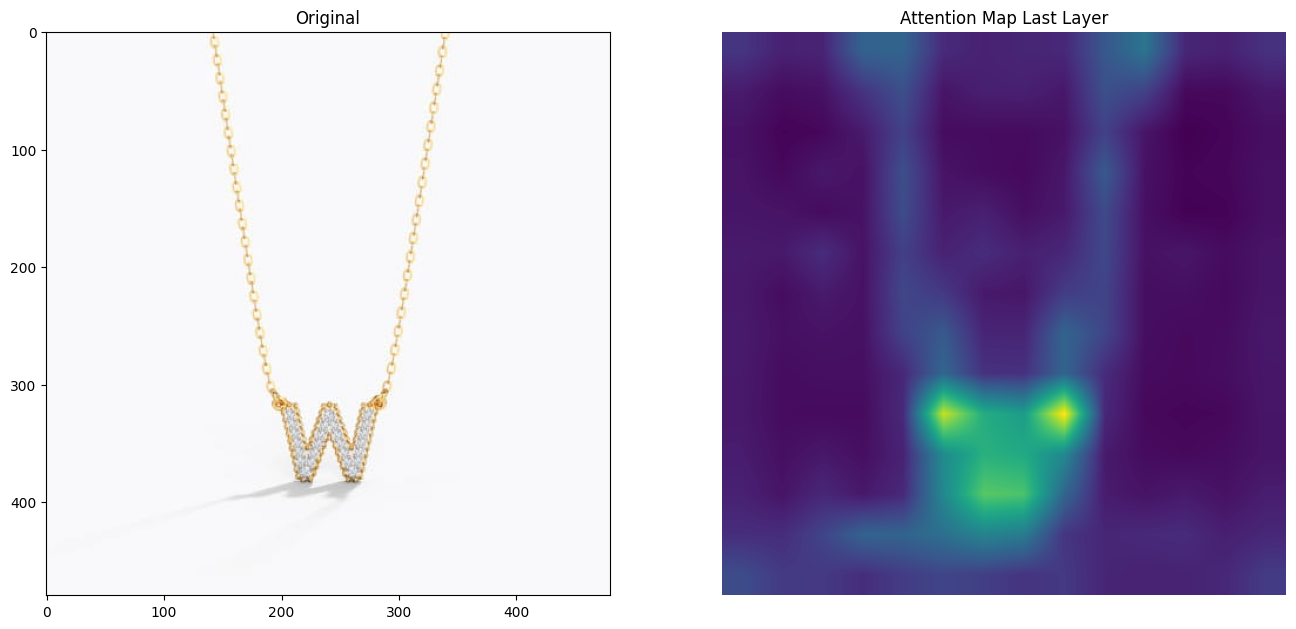

In [ ]:
res = get_attention_map(test_sample, get_mask=True)
plot_attention_map(test_sample, res)